# Training Deep Neural Networks on GPUs in PyTorch

Considering the application of a logistic regression model on th MNIST dataset, it's difficult to improve the accuracy beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. It is possible to improve upon it using a feed-forward neural network able to capture non-linear relationships between inputs and targets.

In [64]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data import, split, and dataloaders

1. Import the MNIST dataset

In [65]:
dataset = MNIST(
    root='data/', 
    download=True, 
    transform=ToTensor()
)

2. Split the training set in training and validation

In [66]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, valid_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(valid_ds)

(50000, 10000)

3. Define the dataloaders

In [67]:
batch_size = 128
num_workers = 4

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=valid_ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

Setting the argument `num_workers` as a positive integer will turn on multi-process data loading with the specified number of loader worker processes

Passing `pin_memory=True` to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

See https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading

Visualize a batch of data in a grid using the `make_grid` function from `torchvision`. Also the `.permute` method has to be used on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

batch_0.shape: torch.Size([128, 1, 28, 28])


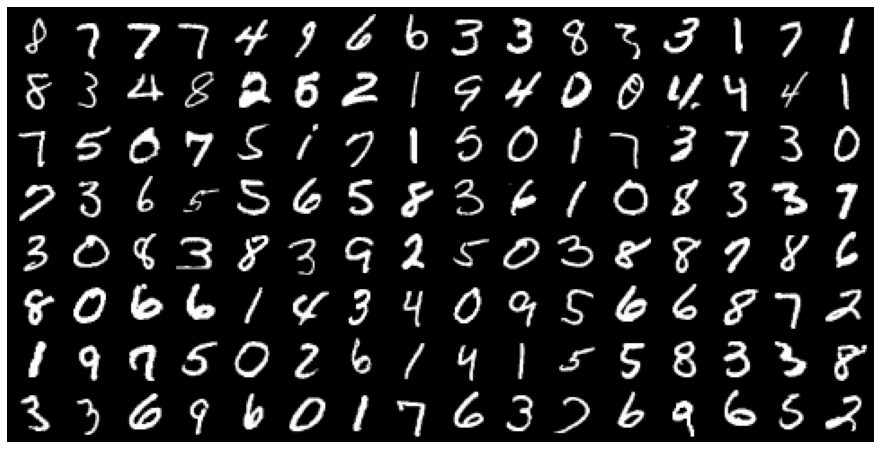

In [68]:
batch_0, _ = list(train_loader)[0]
print('batch_0.shape:', batch_0.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(batch_0, nrow=16).permute((1, 2, 0)))

## Hidden Layers, Activation Functions and Non-Linearity

Create a neural network with two layers: 
- **hidden layer** 
- **output layer**

An **activation function** is going to be inserted between the two layers, to create a non-linear relationship

1. Consider a batch of inputs tensors, and flatten the `1x28x28` image tensors into vectors of size `784`, so they can be passed into an `nn.Linear` object. The flattening is performed using `torch.flatten` (see https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [69]:
batch_0, labels_0 = list(train_loader)[0]
print(batch_0.shape)
input_0 = torch.flatten(batch_0, start_dim=1)
print(input_0.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


2. Define the model for the hidden layer using the `nn.Linear` class with the following parameters
    - the input size is equal to the length of the flattened tensors (784)
    - the output size (i.e. hidden size, in this case) is set to 32

In [70]:
input_size = input_0.shape[-1]
hidden_size = 32

layer1 = nn.Linear(
    in_features=input_size,
    out_features=hidden_size
)

hidden_0 = layer1(input_0)
hidden_0.shape

torch.Size([128, 32])

3. Apply the ReLU activation function
ReLU is a non-linear function, defined as
$$\text{ReLU}(x)=\max{(0,x)}$$
ReLU is implemented in PyTorch with the `relu` function

In [71]:
relu_0 = F.relu(hidden_0)

print(relu_0.shape)
print('min(layer1_outputs):', torch.min(hidden_0).item())
print('min(relu_outputs):', torch.min(relu_0).item())

torch.Size([128, 32])
min(layer1_outputs): -0.6128813028335571
min(relu_outputs): 0.0


4. Define the model for the output layer using the `nn.Linear` class with the following parameters
    - the input size is equal to the length of the ReLU output (that is the hidden layer length) 
    - the output size is set to the number of possible output classes

In [72]:
output_size = 10

layer2 = nn.Linear(hidden_size, output_size)

output_0 = layer2(relu_0)
output_0.shape

torch.Size([128, 10])

5. Compute the cross-entropy loss function

In [73]:
loss_0 = F.cross_entropy(output_0, labels_0)
loss_0

tensor(2.3122, grad_fn=<NllLossBackward0>)

## Model creation using the `nn.Module`

So, the non-linear model (i.e., the neural network) is composed of two `nn.Linear` objects, each one corresponding to a **layer** in the network, and a ReLU activation function between them
- the first layer (also known as the hidden layer) transforms the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64)
- a non-linear **activation function** is applied to the intermediate outputs. The activation function transforms individual elements of the matrix
- the result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size `batch_size x 10`
- the loss is computed on this output and weights and biases are updated using gradient descent

### The model
Define the *accuracy* metric, and then define the model class by extending the `nn.Module` class from PyTorch.

In [74]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.eq(preds,labels)).item() / len(preds))

In [75]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = self.flatten(xb)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Create the model instance, with the following parameters

In [76]:
input_size = 784
hidden_size = 32 # this value can be changed
num_classes = 10

In [77]:
model = MnistModel(
    in_size=input_size, 
    hidden_size=hidden_size, 
    out_size=num_classes
)

Inspect the model variable sizes

In [78]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Try the model forward-passing the first batch of image tensors

In [79]:
outputs = model(batch_0)
loss = F.cross_entropy(outputs, labels_0)
print('Loss:', loss.item())

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2790939807891846
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0284, -0.0202,  0.1499,  0.0475, -0.1319, -0.1079,  0.0301, -0.1610,
         -0.1427,  0.0450],
        [-0.0539,  0.0160,  0.2206,  0.1024, -0.0110, -0.1696,  0.0575, -0.0411,
         -0.0474,  0.1184]])


## Using a GPU
Check if a GPU is available and the required NVIDIA CUDA drivers are installed using the `torch.cuda.is_available()` function

In [80]:
torch.cuda.is_available()

True

1. Define a helper function to ensure that PyTorch uses the GPU if available and defaults to using the CPU if it isn't

In [81]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

2. Define a function that can move data and model to a chosen device

In [82]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [83]:
print(batch_0.device)
batch_0 = to_device(batch_0, get_default_device())
print(batch_0.device)

cpu
cuda:0


3. Define a `DeviceDataLoader` class to wrap the existing data loaders and move batches of data to the selected device. It is not necessary to extend an existing class to create a PyTorch dataloader, all that is needed are 
    - an `__iter__` method to retrieve batches of data 
    - a `__len__` method to get the number of batches

In [84]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Use DeviceDataLoader to wrap the dataloaders

In [85]:
train_loader = DeviceDataLoader(train_loader, get_default_device())
val_loader = DeviceDataLoader(val_loader, get_default_device())

In [86]:
batch_0, labels_0 = list(val_loader)[0]

print(batch_0.device)
print(labels_0.device)

cuda:0
cuda:0


## Training the model

Define two functions
- `fit`: to train the model using gradient descent 
- `evaluate`: to evaluate its performance on the validation set

In [95]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lerning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lerning_rate)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before training the model, be ensure that the data and the model parameters (weights and biases) are on the same device (CPU or GPU). 

Use the defined `to_device` function or the built-in `.to()` function to move the model parameters to the right device

In [92]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes).to(get_default_device())

# Or use:
# model = to_device(model, get_default_device())

model

MnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Check the initial loss and accuracy

In [94]:
history_0 = [evaluate(model, val_loader)]
history_0

[{'val_loss': 2.3019320964813232, 'val_acc': 0.12490110844373703}]

Train the model for 10 epochs

In [96]:
history = fit(
    epochs=10,
    lerning_rate=0.1,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader
)

Epoch [0], val_loss: 0.3610, val_acc: 0.8953
Epoch [1], val_loss: 0.2999, val_acc: 0.9120
Epoch [2], val_loss: 0.2644, val_acc: 0.9224
Epoch [3], val_loss: 0.2423, val_acc: 0.9296
Epoch [4], val_loss: 0.2201, val_acc: 0.9370
Epoch [5], val_loss: 0.2076, val_acc: 0.9396
Epoch [6], val_loss: 0.1950, val_acc: 0.9427
Epoch [7], val_loss: 0.1820, val_acc: 0.9451
Epoch [8], val_loss: 0.1754, val_acc: 0.9481
Epoch [9], val_loss: 0.1691, val_acc: 0.9486


Visualize with a lineplot

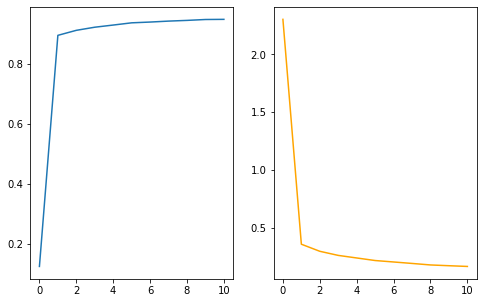

In [98]:
history = history_0 + history

accuracies = [result['val_acc'] for result in history]
losses = [result['val_loss'] for result in history]

fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].plot(range(len(accuracies)),accuracies)
ax[1].plot(range(len(losses)),losses,c='orange')

## Testing with individual images

In [100]:
# Define test dataset
test_dataset = MNIST(
    root='data/',
    train=False,
    transform=ToTensor()
)

Shape: torch.Size([1, 28, 28])
Label: 7


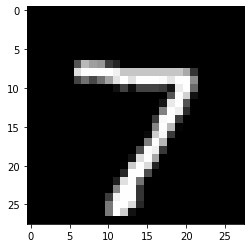

In [104]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)